# Fitting in SATLAS2

SATLAS2 offers the option to do both chisquare and maximum likelihood fits, in some capacity. First, start with importing all required libraries to perform this tutorial:

In [1]:
import sys
import time

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, '..\src')

import satlas2

Define a modified root function to handle uncertainties of 0 counts in a Poisson statistic

In [2]:
def modifiedSqrt(input):
    output = np.sqrt(input)
    output[input <= 0] = 1
    return output

## Gaussian fitting

The most used case will be for data that has some experimental uncertainties. In this case, chisquare fitting is the norm. This assumes a Gaussian uncertainty distribution. For this, a random dataset for an exponential decay is generated.

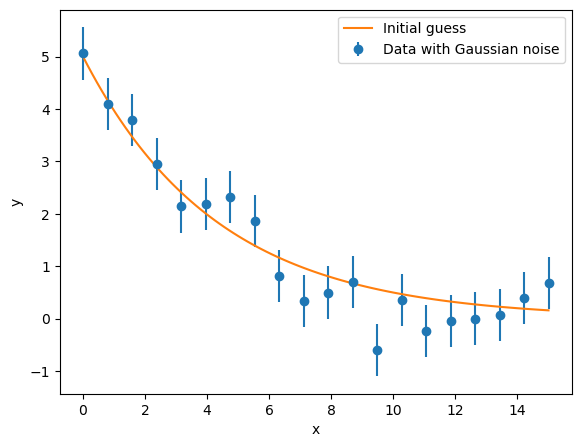

In [3]:
amplitude = 5
halflife = 3
model = satlas2.ExponentialDecay(amplitude, halflife, name='Exp')

rng = np.random.default_rng(0)

data_x = np.linspace(0, 5*halflife, 20)

noise = rng.normal(loc=0, scale=0.5, size=data_x.shape[0])

data_y = model.f(data_x) + noise
yerr = np.ones(data_y.shape) * 0.5

x = np.linspace(0, 5*halflife, 100)
y = model.f(x)

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.errorbar(data_x, data_y, yerr=0.5, fmt='o', label='Data with Gaussian noise')
ax.plot(x, y, label='Initial guess')
ax.set_xlabel('x')
ax.set_ylabel('y')
_ = ax.legend(loc=0)

In order to fit to this data, create a Source where the experimental data is added.

In [4]:
datasource = satlas2.Source(data_x, data_y, yerr=yerr, name='ArtificialData')

This has generated a Source where both the x-values, y-values, and the uncertainty in y is known. As normal in SATLAS2, add the model to the Source and add the Source to a Fitter in order to start the fitting:

In [5]:
datasource.addModel(model)
f = satlas2.Fitter()
f.addSource(datasource)

The normal fitting can be done using the fit() method without any additional parameters.

In [6]:
f.fit()
print(f.reportFit())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 20
    # variables        = 2
    chi-square         = 14.1856875
    reduced chi-square = 0.78809375
    Akaike info crit   = -2.86997486
    Bayesian info crit = -0.87851031
[[Variables]]
    ArtificialData___Exp___amplitude:  5.25120089 +/- 0.33155088 (6.31%) (init = 5)
    ArtificialData___Exp___halflife:   2.70698749 +/- 0.26850056 (9.92%) (init = 3)


Other fitting methods then *leastsq* can be used by using the *method* keyword.

In [7]:
f.revertFit() # To compare performance to normal fitting
f.fit(method='slsqp')
print(f.reportFit())

[[Fit Statistics]]
    # fitting method   = SLSQP
    # function evals   = 21
    # data points      = 20
    # variables        = 2
    chi-square         = 14.1856875
    reduced chi-square = 0.78809375
    Akaike info crit   = -2.86997486
    Bayesian info crit = -0.87851031
[[Variables]]
    ArtificialData___Exp___amplitude:  5.25120090 +/- 0.32314795 (6.15%) (init = 5)
    ArtificialData___Exp___halflife:   2.70698589 +/- 0.25131419 (9.28%) (init = 3)


The LMFIT library exposes the following fitting algorithms for use:

 - ’leastsq’: Levenberg-Marquardt (default)
 - ’least_squares’: Least-Squares minimization, using Trust Region Reflective method
 - ’differential_evolution’: differential evolution
 - ’brute’: brute force method
 - ’basinhopping’: basinhopping
 - ’ampgo’: Adaptive Memory Programming for Global Optimization
 - ’nelder’: Nelder-Mead
 - ’lbfgsb’: L-BFGS-B
 - ’powell’: Powell
 - ’cg’: Conjugate-Gradient
 - ’newton’: Newton-CG
 - ’cobyla’: Cobyla
 - ’bfgs’: BFGS
 - ’tnc’: Truncated Newton
 - ’trust-ncg’: Newton-CG trust-region
 - ’trust-exact’: nearly exact trust-region
 - ’trust-krylov’: Newton GLTR trust-region
 - ’trust-constr’: trust-region for constrained optimization
 - ’dogleg’: Dog-leg trust-region
 - ’slsqp’: Sequential Linear Squares Programming
 - ’emcee’: Maximum likelihood via Monte-Carlo Markov Chain
 - ’shgo’: Simplicial Homology Global Optimization
 - ’dual_annealing’: Dual Annealing optimization

However, some of these methods require the Jacobian or explicit boundaries for all parameters to be provided. Therefore, the following algorithms are recommended as options for SATLAS2:
 - ’leastsq’: Levenberg-Marquardt (default)
 - ’least_squares’: Least-Squares minimization, using Trust Region Reflective method
 - ’basinhopping’: basinhopping
 - ’ampgo’: Adaptive Memory Programming for Global Optimization
 - ’nelder’: Nelder-Mead
 - ’lbfgsb’: L-BFGS-B
 - ’powell’: Powell
 - ’cg’: Conjugate-Gradient
 - ’cobyla’: Cobyla
 - ’bfgs’: BFGS
 - ’tnc’: Truncated Newton
 - ’trust-constr’: trust-region for constrained optimization
 - ’slsqp’: Sequential Linear Squares Programming
 - ’emcee’: Maximum likelihood via Monte-Carlo Markov Chain
 As an example, the generated data is fitted with each of these algorithms, to show they give functionally the same answer. However, keep in mind that the speed and success of each algorithm depends on the data and model used, so not all algorithms may be suitable! As a rule of thumb, the least squares algorithms are among the most stable and widely applicable.

In [8]:
methods = ['leastsq',
 'least_squares',
 'basinhopping',
 'ampgo',
 'nelder',
 'lbfgsb',
 'powell',
 'cg',
 'cobyla',
 'bfgs',
 'tnc',
 'trust-constr',
 'slsqp']

In [9]:
evals = []
for m in methods:
    f.revertFit()
    f.fit(method=m)
    evals.append(f.result.nfev)
    print(f.reportFit())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 20
    # variables        = 2
    chi-square         = 14.1856875
    reduced chi-square = 0.78809375
    Akaike info crit   = -2.86997486
    Bayesian info crit = -0.87851031
[[Variables]]
    ArtificialData___Exp___amplitude:  5.25120089 +/- 0.33155088 (6.31%) (init = 5)
    ArtificialData___Exp___halflife:   2.70698749 +/- 0.26850056 (9.92%) (init = 3)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 7
    # data points      = 20
    # variables        = 2
    chi-square         = 14.1856875
    reduced chi-square = 0.78809375
    Akaike info crit   = -2.86997486
    Bayesian info crit = -0.87851031
[[Variables]]
    ArtificialData___Exp___amplitude:  5.25120089 +/- 0.33154988 (6.31%) (init = 5)
    ArtificialData___Exp___halflife:   2.70698749 +/- 0.26850333 (9.92%) (init = 3)
[[Fit Statistics]]
    # fitting method   = basinhopping
    # functi

C:\Users\megat\.conda\envs\satlas2\Lib\site-packages\lmfit\_ampgo.py:277: RuntimeWarning: overflow encountered in scalar power
  numerator = (objfun(x0, *fun_args) - aspiration)**2
C:\Users\megat\.conda\envs\satlas2\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 5232
    # data points      = 20
    # variables        = 2
    chi-square         = 14.1856875
    reduced chi-square = 0.78809375
    Akaike info crit   = -2.86997486
    Bayesian info crit = -0.87851031
[[Variables]]
    ArtificialData___Exp___amplitude:  5.25120344 +/- 0.32314799 (6.15%) (init = 5)
    ArtificialData___Exp___halflife:   2.70698421 +/- 0.25131396 (9.28%) (init = 3)
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 58
    # data points      = 20
    # variables        = 2
    chi-square         = 14.1856875
    reduced chi-square = 0.78809375
    Akaike info crit   = -2.86997483
    Bayesian info crit = -0.87851028
[[Variables]]
    ArtificialData___Exp___amplitude:  5.25120285 +/- 0.32314600 (6.15%) (init = 5)
    ArtificialData___Exp___halflife:   2.70695228 +/- 0.25130868 (9.28%) (init = 3)
[[Fit Statistics]]
    # fitting method

C:\Users\megat\.conda\envs\satlas2\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


C:\Users\megat\AppData\Local\Temp\ipykernel_15512\2990995001.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels, rotation = 45, ha="right")


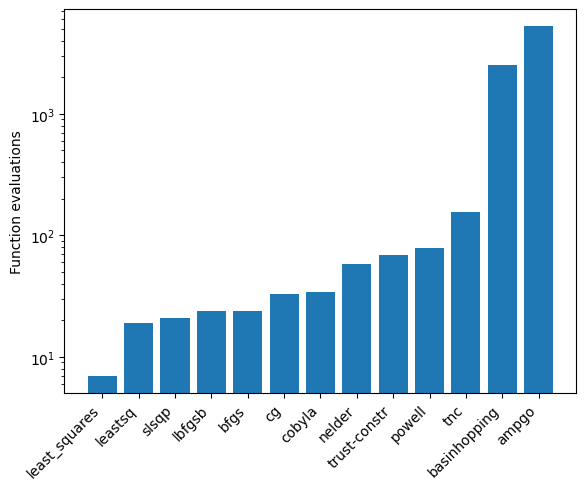

In [10]:
indices = np.argsort(evals)
m = np.array(methods)
e = np.array(evals)
m = m[indices]
e = e[indices]
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(m, e)
ax.set_yscale('log')
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, rotation = 45, ha="right")
_ = ax.set_ylabel('Function evaluations')

From experimenting with simulated and actual hyperfine laser spectroscopic data, the `slsqp` algorithm was found to offer both a relatively fast and stable platform.

## Adding prior to parameters

Suppose a literature value is known and has to be applied to a parameter as an additional constraint. This can be viewed as a prior, or alternatively as an additional data point to fit to. A Gaussian prior can easily be added via the `setParamPrior` method of the Fitter object.

In [11]:
f.revertFit()
f.fit()
print(f.reportFit()) # Fit without prior
f.revertFit()
f.setParamPrior('ArtificialData', 'Exp', 'halflife', 3, 0.1) # Add prior to fit the halflife of model Exp in the source ArtificialData to 3+/-0.1
f.fit()
print(f.reportFit())
f.revertFit()
f.setParamPrior('ArtificialData', 'Exp', 'halflife', 3, 0.5) # Change the prior 3+/-0.5
f.fit()
print(f.reportFit())
f.revertFit()
f.removeParamPrior('ArtificialData', 'Exp', 'halflife') # Remove the prior
f.fit()
print(f.reportFit())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 20
    # variables        = 2
    chi-square         = 14.1856875
    reduced chi-square = 0.78809375
    Akaike info crit   = -2.86997486
    Bayesian info crit = -0.87851031
[[Variables]]
    ArtificialData___Exp___amplitude:  5.25120089 +/- 0.33155088 (6.31%) (init = 5)
    ArtificialData___Exp___halflife:   2.70698749 +/- 0.26850056 (9.92%) (init = 3)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 21
    # variables        = 2
    chi-square         = 15.0536495
    reduced chi-square = 0.79229734
    Akaike info crit   = -2.99094168
    Bayesian info crit = -0.90189680
[[Variables]]
    ArtificialData___Exp___amplitude:  5.04903680 +/- 0.25418730 (5.03%) (init = 5)
    ArtificialData___Exp___halflife:   2.97175885 +/- 0.08528185 (2.87%) (init = 3)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals  

## Fitting with likelihood data

The fitting can also proceed by maximizing the likelihood (or rather, minimizing the negative loglikelihood) instead of minimizing the chisquare. In order to do this, use the *llh=True* parameter in the fitting routine.

Currently, there are two options for the likelihood, which can be set with the *llh_method* keyword: *gaussian* (the default) and *poisson*. When the likelihood fitting is used, the *leastsq* and *least_squares* methods cannot be applied since the negative loglikelihood is no longer a sum of squares, an assumption which is critical in these algorithms.

In [12]:
f.revertFit()
f.fit(llh=True)
print(f.reportFit())
f.revertFit()
f.setParamPrior('ArtificialData', 'Exp', 'halflife', 3, 0.1) # Prior of 3+/-0.1
f.fit(llh=True)
print(f.reportFit())

[[Fit Statistics]]
    # fitting method   = SLSQP
    # function evals   = 20
    # data points      = 20
    # variables        = 2
    chi-square         = 8.21548506
    reduced chi-square = 0.45641584
    Akaike info crit   = -13.7942296
    Bayesian info crit = -11.8027650
[[Variables]]
    ArtificialData___Exp___amplitude:  5.25117472 +/- 0.51478516 (9.80%) (init = 5)
    ArtificialData___Exp___halflife:   2.70699167 +/- 0.40035373 (14.79%) (init = 3)
[[Fit Statistics]]
    # fitting method   = SLSQP
    # function evals   = 15
    # data points      = 21
    # variables        = 2
    chi-square         = 9.84186102
    reduced chi-square = 0.51799269
    Akaike info crit   = -11.9154300
    Bayesian info crit = -9.82638508
[[Variables]]
    ArtificialData___Exp___amplitude:  5.04906321 +/- 0.40525527 (8.03%) (init = 5)
    ArtificialData___Exp___halflife:   2.97176292 +/- 0.13544977 (4.56%) (init = 3)


Notice that the reduced chisquare is still reported. However, in this mode, it *no longer* is a valid statistical measure to look at! This is also the reason why the uncertainties are different. The estimation of the uncertainties is done by numerically approximating the Hessian matrix of the problem and inverting it, and this is also done in the chisquare methods. The reason it now differs is twofold:
 - The matrix describing the problem is different, hence some numerical approximations can give slightlly different results.
 - Since the reduced chisquare is no longer a valid statistical measure, it can no longer be used to scale the uncertainties!

## Using Poisson likelihood

Up to here, the likelihood fitting was focused on Gaussian uncertainties, but a Poisson statistic can also be used for the likelihood calculation. This option will be illustrated on artificial hyperfine data.

C:\Users\megat\Documents\git_repositories\personal\satlas2\examples\..\src\satlas2\models\hfsModel.py:284: RuntimeWarning: invalid value encountered in scalar divide
  shift = phase * n / d


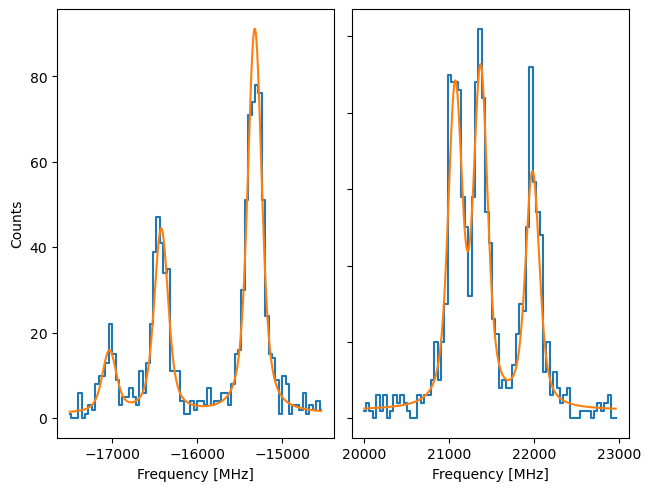

In [13]:
spin = 3.5
J = [0.5, 1.5]
A = [9600, 175]
B = [0, 315]
C = [0, 0]
FWHMG = 135
FWHML = 101
centroid = 480
bkg = 1
scale = 90

x = np.arange(-17500, -14500, 40)
x = np.hstack([x, np.arange(20000, 23000, 40)])

rng = np.random.default_rng(0)
f = satlas2.Fitter()
hfs = satlas2.HFS(spin,
                  J,
                  A=A,
                  B=B,
                  C=C,
                  scale=scale,
                  df=centroid,
                  name='HFS1',
                  racah=True,
                  fwhmg=FWHMG,
                  fwhml=FWHML)
bkgm = satlas2.Polynomial([bkg], name='bkg1')
y = hfs.f(x) + bkgm.f(x)
y = rng.poisson(y)

datasource = satlas2.Source(x,
                            y,
                            yerr=modifiedSqrt,
                            name='Scan1')

datasource.addModel(hfs)
datasource.addModel(bkgm)
f.addSource(datasource)

def plot_hfs(f):
    fig = plt.figure(constrained_layout=True)
    gs = gridspec.GridSpec(nrows=len(f.sources), ncols=2, figure=fig)
    a1 = None
    a2 = None
    axes = []
    for i, (name, datasource) in enumerate(f.sources):
        if a1 is None:
            ax1 = fig.add_subplot(gs[i, 0])
            ax2 = fig.add_subplot(gs[i, 1])
            a1 = ax1
            a2 = ax2
        else:
            ax1 = fig.add_subplot(gs[i, 0], sharex=a1)
            ax2 = fig.add_subplot(gs[i, 1], sharex=a2)
        left = datasource.x < 0
        right = datasource.x > 0
        smooth_left = np.arange(datasource.x[left].min(), datasource.x[left].max(),
                                5.0)
        smooth_right = np.arange(datasource.x[right].min(),
                                 datasource.x[right].max(), 5.0)
        ax1.plot(datasource.x[left],
                 datasource.y[left],
                 drawstyle='steps-mid',
                 label='Data')
        ax1.plot(smooth_left, datasource.evaluate(smooth_left), label='Fit')
        ax2.plot(datasource.x[right],
                 datasource.y[right],
                 drawstyle='steps-mid',
                 label='Data')
        ax2.plot(smooth_right, datasource.evaluate(smooth_right), label='Fit')
        ax1.set_xlabel('Frequency [MHz]')
        ax2.set_xlabel('Frequency [MHz]')
        ax1.set_ylabel('Counts')
        ax2.set_ylabel('Counts')
        ax1.label_outer()
        ax2.label_outer()
        axes.append([ax1, ax2])
plot_hfs(f)

Notice that here, the *yerr* supplied to the Source is not an array, but instead a function. When this is the case, the uncertainty on y is calculated by applying the function to the sum of the underlying models. In this case, this would give rise to using Pearson's chisquare, where the uncertainty on the datapoint is given by sqrt(f(x)). A preliminary fit can be done by using the normal chisquare fitting.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 150
    # variables        = 9
    chi-square         = 145.269585
    reduced chi-square = 1.03028075
    Akaike info crit   = 13.1933897
    Bayesian info crit = 40.2891074
[[Variables]]
    Scan1___HFS1___centroid:  479.080652 +/- 3.21746540 (0.67%) (init = 480)
    Scan1___HFS1___Al:        9602.87663 +/- 2.38671593 (0.02%) (init = 9600)
    Scan1___HFS1___Au:        176.326689 +/- 1.06392978 (0.60%) (init = 175)
    Scan1___HFS1___Bl:        0 (fixed)
    Scan1___HFS1___Bu:        320.837279 +/- 8.31152333 (2.59%) (init = 315)
    Scan1___HFS1___Cl:        0 (fixed)
    Scan1___HFS1___Cu:        0.28989910 +/- 0.64811694 (223.57%) (init = 0)
    Scan1___HFS1___FWHMG:     124.983341 +/- 20.4156381 (16.33%) (init = 135)
    Scan1___HFS1___FWHML:     115.427693 +/- 16.2067806 (14.04%) (init = 101)
    Scan1___HFS1___scale:     93.1256961 +/- 4.04213456 (4.34%) (init = 90)
    Scan

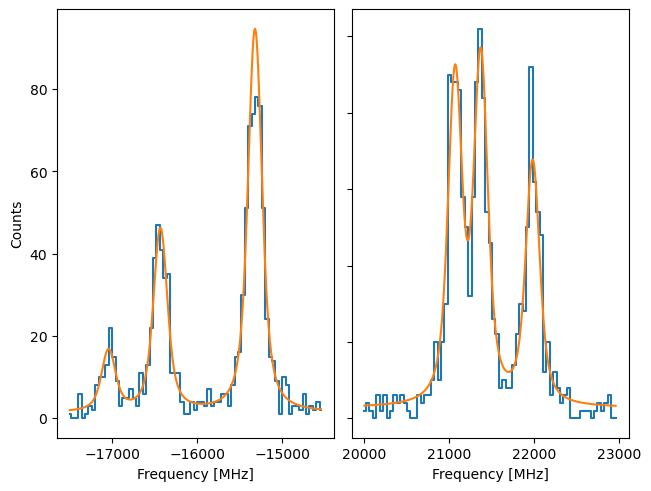

In [14]:
f.fit()
plot_hfs(f)
print(f.reportFit())

We can see the difference by comparing to a Source where the uncertainty in y is given by the square root:

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 150
    # variables        = 9
    chi-square         = 154.121394
    reduced chi-square = 1.09305953
    Akaike info crit   = 22.0657907
    Bayesian info crit = 49.1615083
[[Variables]]
    Scan1___HFS1___centroid:  478.154621 +/- 3.14574744 (0.66%) (init = 480)
    Scan1___HFS1___Al:        9603.17923 +/- 2.31958026 (0.02%) (init = 9600)
    Scan1___HFS1___Au:        175.647786 +/- 1.02796818 (0.59%) (init = 175)
    Scan1___HFS1___Bl:        0 (fixed)
    Scan1___HFS1___Bu:        324.809730 +/- 8.15037743 (2.51%) (init = 315)
    Scan1___HFS1___Cl:        0 (fixed)
    Scan1___HFS1___Cu:        0.53845248 +/- 0.60603004 (112.55%) (init = 0)
    Scan1___HFS1___FWHMG:     155.650402 +/- 15.1637100 (9.74%) (init = 135)
    Scan1___HFS1___FWHML:     81.1159557 +/- 13.7997440 (17.01%) (init = 101)
    Scan1___HFS1___scale:     91.2170265 +/- 3.69217065 (4.05%) (init = 90)
    Scan1

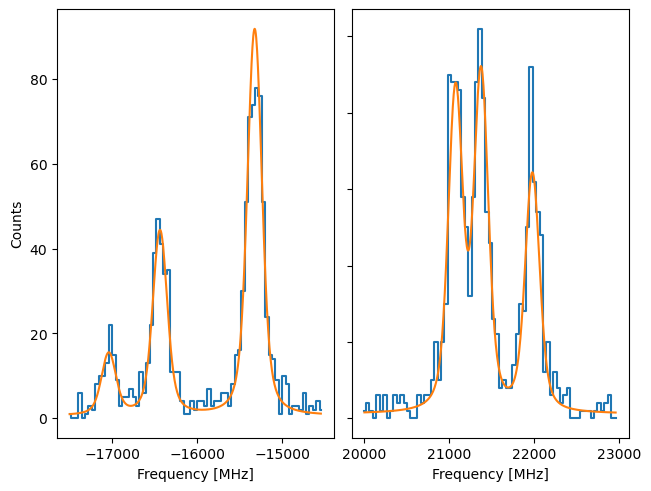

In [15]:
yerr = modifiedSqrt(y)
f2 = satlas2.Fitter()
hfs2 = satlas2.HFS(spin,
                   J,
                   A=A,
                   B=B,
                   C=C,
                   scale=scale,
                   df=centroid,
                   name='HFS1',
                   racah=True,
                   fwhmg=FWHMG,
                   fwhml=FWHML)
bkgm2 = satlas2.Polynomial([bkg], name='bkg1')

datasource2 = satlas2.Source(x,
                             y,
                             yerr=yerr,
                             name='Scan1')
datasource2.addModel(hfs2)
datasource2.addModel(bkgm2)
f2.addSource(datasource2)
f2.fit()
plot_hfs(f2)
print(f2.reportFit())

While not extremely large, there is a noticable difference between the results. The Pearson's chisquare is recommended since this is the better approximation of the Poisson statistics.

However, the Poisson likellihood can also be used to fit the spectrum:

[[Fit Statistics]]
    # fitting method   = SLSQP
    # function evals   = 352
    # data points      = 150
    # variables        = 9
    chi-square         = 527352.919
    reduced chi-square = 3740.09163
    Akaike info crit   = 1242.74850
    Bayesian info crit = 1269.84422
[[Variables]]
    Scan1___HFS1___centroid:  479.100498 +/- 4.33540143 (0.90%) (init = 480)
    Scan1___HFS1___Al:        9602.92877 +/- 3.15571496 (0.03%) (init = 9600)
    Scan1___HFS1___Au:        176.139831 +/- 1.41620285 (0.80%) (init = 175)
    Scan1___HFS1___Bl:        0 (fixed)
    Scan1___HFS1___Bu:        322.342053 +/- 11.1549535 (3.46%) (init = 315)
    Scan1___HFS1___Cl:        0 (fixed)
    Scan1___HFS1___Cu:        0.34832071 +/- 0.85322189 (244.95%) (init = 0)
    Scan1___HFS1___FWHMG:     126.456110 +/- 24.3380985 (19.25%) (init = 135)
    Scan1___HFS1___FWHML:     114.497431 +/- 19.7530675 (17.25%) (init = 101)
    Scan1___HFS1___scale:     93.0381465 +/- 5.32651291 (5.73%) (init = 90)
    Scan1

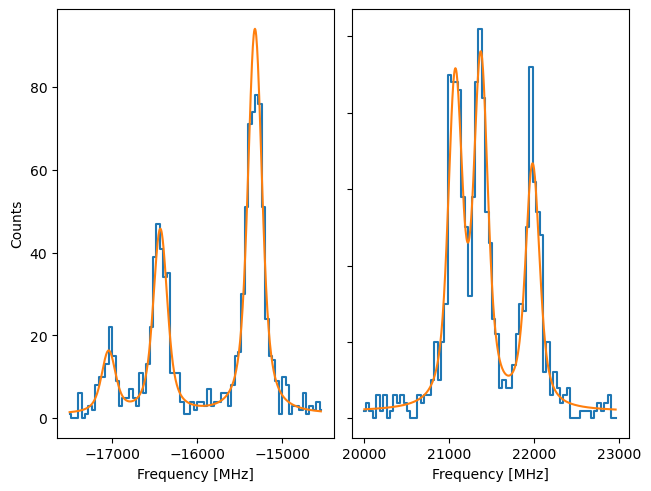

In [16]:
f.revertFit()
f.fit(llh=True, llh_method='poisson')
print(f.reportFit())
plot_hfs(f)

Here, it's more than clear that the (reduced) chisquare is not usable, since LMFIT internally *assumes* what is returned in the cost function is the chisquare statistic.

## Using `emcee`

One option that is given by LMFIT as an optimizer but not demonstrated is the `emcee` option. Using this, the returned value is treated as a loglikelihood for a random walk algorithm. By using many walkers to sample the loglikelihood, a very good approximation of the probability density function is generated. For more information, see the documentation of the `emcee` package.

Here, the basic usage in SATLAS2 will be illustrated, along with some advanced topic to modify the working of the underlying algorithm.

In [17]:
f.revertFit()
f.fit(llh=True, llh_method='poisson', method='emcee', steps=1000, nwalkers=50)
print(f.reportFit())

 18%|███████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                | 179/1000 [00:01<00:08, 92.05it/s]C:\Users\megat\Documents\git_repositories\personal\satlas2\examples\..\src\satlas2\core.py:367: RuntimeWarning: invalid value encountered in log
  returnvalue = self.temp_y * np.log(model_calcs) - model_calcs
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.95it/s]
C:\Users\megat\.conda\envs\satlas2\Lib\site-packages\numpy\lib\function_base.py:2854: 

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [56.03746971 50.19572236 48.76119684 54.62125998         nan 55.75800502
 57.46850239 48.427324   51.04319725]
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 1
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = -8148.27696
    Bayesian info crit = -8166.27696
[[Variables]]
    Scan1___HFS1___centroid:  478.754968 +/- 3.36112524 (0.70%) (init = 480)
    Scan1___HFS1___Al:        9602.88489 +/- 2.47289183 (0.03%) (init = 9600)
    Scan1___HFS1___Au:        176.147526 +/- 1.09427588 (0.62%) (init = 175)
    Scan1___HFS1___Bl:        0 (fixed)
    Scan1___HFS1___Bu:        322.133034 +/- 8.61135651 (2.67%) (init = 315)
    Scan1___HFS1___Cl:        0 (fixed)
    Scan1___HFS1___Cu:        0.00000000 +/

C:\Users\megat\.conda\envs\satlas2\Lib\site-packages\lmfit\printfuncs.py:177: RuntimeWarning: invalid value encountered in scalar divide
  spercent = f'({abs(par.stderr/par.value):.2%})'


The results of the fitting are calculated by taking the median of the samples as the central value, and the average of the one-sided 1-sigma as the general uncertainty on the parameter. However, fitting this way loses some information, since there is no saved record of the sampled parameters, and the validity of the walk cannot be tested. In particular, note that Cu has a peculiar value which requires some investigation.

In order to do this, the chain of samples can be saved by specifying a filename:

In [18]:
f.revertFit()
filename = 'emceeDemonstration.h5'
f.fit(llh=True, llh_method='poisson', method='emcee', steps=1000, nwalkers=50, filename=filename)
print(f.reportFit())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.99it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [57.04341752 53.56998762 54.11377706 55.15716973         nan 53.95575965
 60.18713051 50.04226876 55.48363343]
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 1
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = -8148.29278
    Bayesian info crit = -8166.29278
[[Variables]]
    Scan1___HFS1___centroid:  479.119418 +/- 3.23737942 (0.68%) (init = 480)
    Scan1___HFS1___Al:        9602.76065 +/- 2.51181010 (0.03%) (init = 9600)
    Scan1___HFS1___Au:        176.127101 +/- 1.10213818 (0.63%) (init = 175)
    Scan1___HFS1___Bl:        0 (fixed)
    Scan1___HFS1___Bu:        320.765821 +/- 8.85014810 (2.76%) (init = 315)
    Scan1___HFS1___Cl:        0 (fixed)
    Scan1___HFS1___Cu:        0.00000000 +/

The fit resulted in the same parametervalues, so the saved chain can be used to analyse why Cu is causing issues. In order to do this, one of the ways to visualise the result is by looking at the plot of the walkers:

bkg1 p0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 27.19it/s]


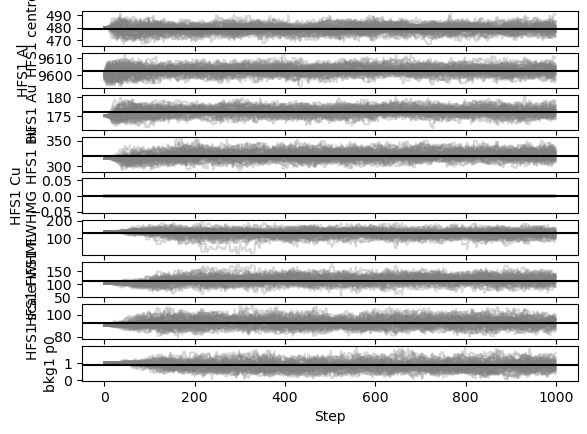

In [19]:
_ = satlas2.generateWalkPlot(filename)

As the walkers progress towards their 1000 steps, nearly all parameters leave their phase of only exploring a tiny bit around the initial value and properly spread out. This burn-in phase is generally regarded as an undesired feature of the random walk algorithm and is normally discarded. Based on this plot, a claim for a burn-in phase of about 200 steps can be made.

In order to see the results for Cu in more detail, the results can be filtered:

HFS1 Cu: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s]


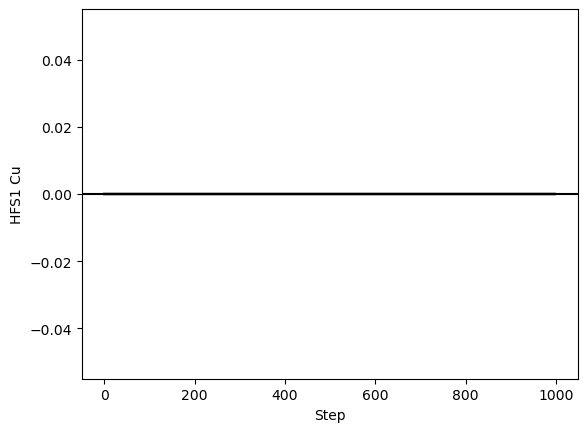

In [20]:
_ = satlas2.generateWalkPlot(filename, filter=['Cu'])

As can be seen here, there is absolutely no variation in the Cu value. One of the possibilities that spring to mind is that the boundaries put on the parameter force it to be 0. If that were the case however, the fitting with other routines would also have restricted the value to 0, which it hasn't. Another assumption is that the value of *exactly* 0 can be an issue for the random walker. This can be tested by reverting the fit, slightly adjusting the value (either directly or by doing a preliminary fit), and performing the random walk again.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.63it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 9 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [49.79535749 56.83821005 52.78761371 54.3836919  49.65206895 47.99592459
 50.88289254 49.70732336 74.38901137]


HFS1 Au: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 34.89it/s]


[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 1
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = -8148.56089
    Bayesian info crit = -8166.56089
[[Variables]]
    Scan1___HFS1___centroid:  479.179130 +/- 3.15197251 (0.66%) (init = 479.0807)
    Scan1___HFS1___Al:        9603.03121 +/- 2.31025284 (0.02%) (init = 9602.877)
    Scan1___HFS1___Au:        176.165779 +/- 1.01302344 (0.58%) (init = 176.3267)
    Scan1___HFS1___Bl:        0 (fixed)
    Scan1___HFS1___Bu:        322.223737 +/- 7.69174619 (2.39%) (init = 320.8373)
    Scan1___HFS1___Cl:        0 (fixed)
    Scan1___HFS1___Cu:        0.29007848 +/- 0.48222380 (166.24%) (init = 0.2898991)
    Scan1___HFS1___FWHMG:     126.034020 +/- 16.4263323 (13.03%) (init = 124.9833)
    Scan1___HFS1___FWHML:     114.134035 +/- 13.4331215 (11.77%) (init = 115.4277)
    Scan1___HFS1___scale:     92.8760544 +/- 3

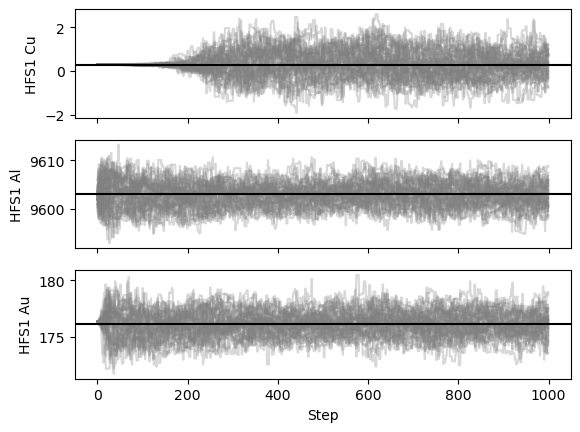

In [21]:
f.revertFit()
f.fit()
filename = 'emceeDemonstrationCu.h5'
f.fit(llh=True, llh_method='poisson', method='emcee', steps=1000, nwalkers=50, filename=filename)
satlas2.generateWalkPlot(filename, filter=['Cu', 'Al', 'Au'])
print(f.reportFit())

This shows that indeed, the value of exactly 0 is an issue for the random walker!

However, the small value of Cu in general lead to a much larger burn-in time, now more along the lines of 300-400 steps. By utilizing a burn-in time of 400 steps, more than enough samples are still present to generate a corner plot, where the 1D and 2D distributions of the samples is presented.

Scan1                                                                                                                                                                                                                                                                                                                                  | 0/45.0 [00:00<?, ?it/s]
Scan1 centroid:   0%|                                                                                                                                                                                                                                                                                                            | 0/45.0 [00:00<?, ?it/s]
Scan1 centroid:   2%|██████▍                                                                                                                                                                                                                                                                                

Scan1 FWHMG:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 20/45.0 [00:00<00:01, 17.68it/s]
 HFS1 Au, Scan1
Scan1 FWHMG:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 21/45.0 [00:00<00:01, 17.68it/s]
 HFS1 Au, Scan1
Scan1 FWHMG:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 22/45.0 

Scan1 p0:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 41/45.0 [00:01<00:00, 50.34it/s]
 HFS1 FWHMG, Scan1
Scan1 p0:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 42/45.0 [00:01<00:00, 50.34it/s]
 HFS1 FWHMG, Scan1
Scan1 p0:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 43/45.0 

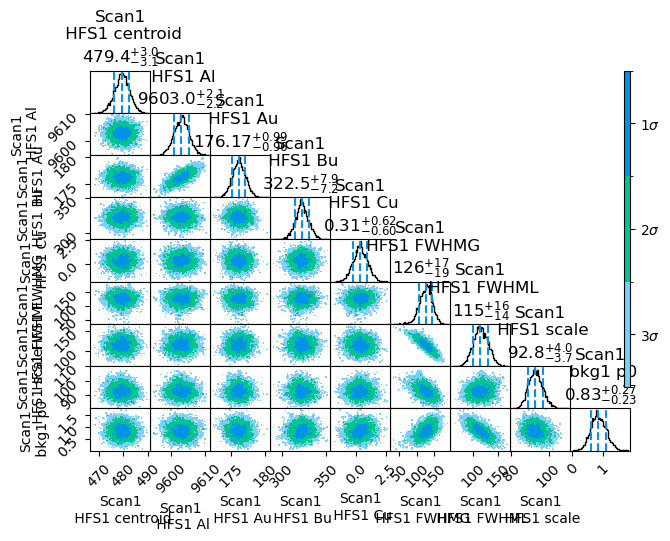

In [22]:
_ = satlas2.generateCorrelationPlot(filename, burnin=400)

For clarity, this plot can also be filtered to only the parameters that are of interest. For further modification, the binning can be reduced with keywords:

Scan1                                                                                                                                                                                                                                                                                                                                   | 0/6.0 [00:00<?, ?it/s]
Scan1 Al:   0%|                                                                                                                                                                                                                                                                                                                   | 0/6.0 [00:00<?, ?it/s]
Scan1 Al:  17%|█████████████████████████████████████████████████▊                                                                                                                                                                                                                                           

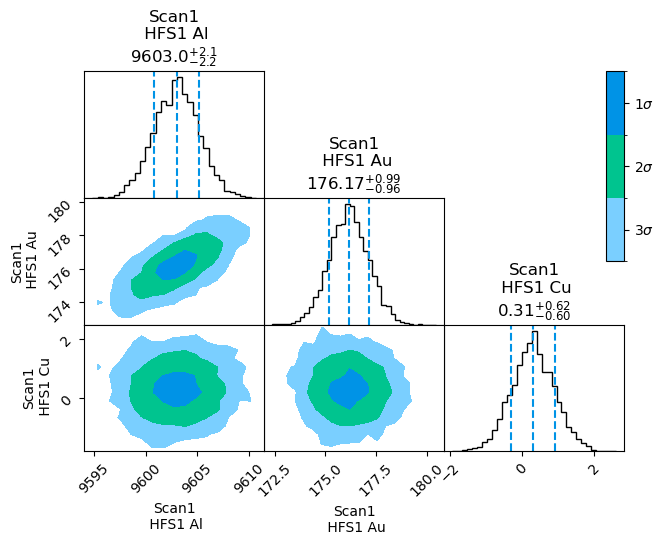

In [23]:
_ = satlas2.generateCorrelationPlot(filename, filter=['Al', 'Au', 'Cu'], burnin=400, binreduction=2, bin2dreduction=2)

Now only the hyperfine parameters are shown. The number of bins in the 1D case has been reduced by a factor 2, and the number of bins in the 2D case by a further factor of 2, for a total reduction of 4 compared to the previous plot.

Overall, the results here are shown to be quite Gaussian, and can be used in the normal way. One more adaptation that can be made is removing the burn-in from the results. This can be done by processing the random walk with the *readWalk* method of the Fitter.

In [24]:
f.readWalk(filename, burnin=400)
print(f.reportFit())

The chain is shorter than 50 times the integrated autocorrelation time for 9 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 12;
tau: [45.62991851 40.32541678 37.45399196 39.03747261 40.87049522 37.94803522
 40.69432958 39.98245743 37.78922749]
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 30000
    # data points      = unknown
    # variables        = 9
    chi-square         = unknown
    reduced chi-square = unknown
    Akaike info crit   = unknown
    Bayesian info crit = unknown
[[Variables]]
    Scan1___HFS1___centroid:  479.423946 +/- 3.02033029 (0.63%) (init = 479.1791)
    Scan1___HFS1___Al:        9603.01272 +/- 2.17492439 (0.02%) (init = 9603.031)
    Scan1___HFS1___Au:        176.168601 +/- 0.97595651 (0.55%) (init = 176.1658)
    Scan1___HFS1___Bl:        0 (fixed)
    Scan1___HFS1___Bu:        322.518878 +/- 7.52505337 (2.33%) (init = 322.2237)
    Scan1___HFS1___Cl:        0 (fixed)
    Scan1___HFS1___Cu:        0.

The burnin has been processed correctly, as the value of e.g. Cu has been modified from 0.29+/-0.48 to 0.3+/-0.6, which is what the processed plot shows it should be.